## Ajuste fino do BERT para classificação de texto
***

Classificação de SMS. Identificacao de SPAM
***

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 3.9 MB/s 
     |████████████████████████████████| 7.6 MB 67.2 MB/s 
     |████████████████████████████████| 163 kB 78.0 MB/s 


In [ ]:
#Importando as bibliotecas/dependências necessárias
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

* Baixando o dataset utilizado

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

In [ ]:
!unzip -o smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
!head -10 SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

* Transformando conjunto de dados em dataframe
***

In [ ]:
file_path = '/content/SMSSpamCollection'
df = pd.DataFrame({'label':int(), 'text':str()}, index = [])
with open(file_path) as f:
  for line in f.readlines():
    split = line.split('\t')
    df = df.append({'label': 1 if split[0] == 'spam' else 0,
                    'text': split[1]},
                    ignore_index = True)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


definindo feature de entrada e as classes. Padrão de nome do bert (text e labels)
***

In [ ]:
text = df.text.values
labels = df.label.values

Tokeninando com o Bert tokenizer


In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Observando como o bert tokeniza e mapeia os tokens de

In [11]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))


In [12]:
print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ happy    │        3407 │
├──────────┼─────────────┤
│ new      │        2047 │
├──────────┼─────────────┤
│ year     │        2095 │
├──────────┼─────────────┤
│ my       │        2026 │
├──────────┼─────────────┤
│ no       │        2053 │
├──────────┼─────────────┤
│ .        │        1012 │
├──────────┼─────────────┤
│ 1        │        1015 │
├──────────┼─────────────┤
│ man      │        2158 │
╘══════════╧═════════════╛


### Etapas de preprocessamento exigidas para entrada do BERT
***


1.   Tokens especiais
  - [CLS]: Adicionado no inicio de cada sentença(ID correspondente no BERT: 101)
  - [SEP]: Adicionado no final de cada sentença (ID correspondente no BERT: 102)
2.   Padronizar o tamanho das sentenças (Fazer todas do mesmo tamanho)
  - As sentenças maiores que 512 tokens são truncadas e as menores são preenchidas com o token especial [PAD]. O ID correspondente no BERT para o [PAD] é O
3. Criando uma attention mask
  - indica os tokens que devem ser considerados no aprendizado. É uma lista de zeros e uns. Zeros indica que o token é um [PAD], portanto não tem elemento que contribue pra o aprendizado e deve ser ignorado.



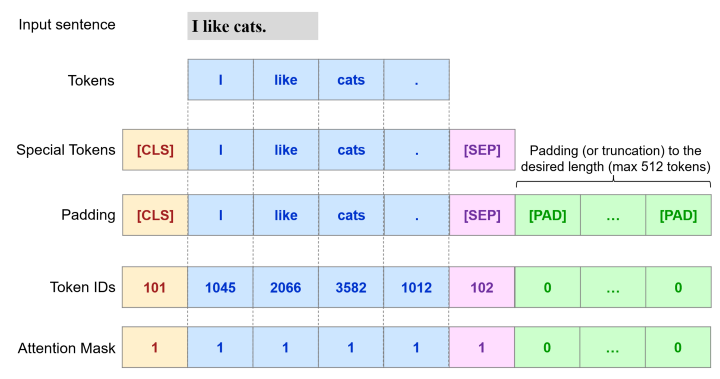

Utilizando o método `encode_plus` para fazer as três etapas desse processo. Retornando:
- input_ids: lista de ids do tokens de acordo com o BERT
- token_type_ids: list especificando os tipos dos IDs
- attention_mask: lsita de zeros e uns marcando onde é um token válido e onde é padding ([PAD]). Especificando `return_attention_mask = True` no parametro do método.


In [13]:

token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

In [14]:
for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Exemplo de ids dos tokens
***
  - O primeiro token (101) é o [CLS]
  - O tokens que estão entre 101 e 102 correspondem aos tokens válidos da sentença
  - o token 102 é o [SEP]
  - os tokens zeros após [SEP] são paddings [PAD]
  - O tamanho do tensor foi definido como 32 arbitrariamente. O tamanho máximo é 512

In [33]:
token_id[1]

tensor([  101,  7929,  2474,  2099,  1012,  1012,  1012, 16644, 15536,  2546,
         1057,  2006,  2072,  1012,  1012,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [34]:
#Visualizando o mapeamento da sentença com o bert
def print_rand_sentence_encoding():
  index = 1 #random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))


In [35]:
print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ok       │        7929 │                1 │
├──────────┼─────────────┼──────────────────┤
│ la       │        2474 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##r      │        2099 │                1 │
├──────────┼─────────────┼──────────────────┤
│ .        │        1012 │                1 │
├──────────┼─────────────┼──────────────────┤
│ .        │        1012 │                1 │
├──────────┼─────────────┼──────────────────┤
│ .        │        1012 │                1 │
├──────────┼─────────────┼──────────────────┤
│ joking   │       16644 │                1 │
├──────────┼─────────────┼──────────────────┤
│ wi       │       15536 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##f      │        2546 │        

### Divindo os dados em conjunto de trainamente e validação
***

In [36]:
val_ratio = 0.2 #Divisão feita em: 80% para treino e 20% para validação. de forma estratificada, de acordo com as labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])



Um iterador para o dataset é criado usando a classe `torch.DataLoader`. O `DataLoader` é responsável por selecionar aleatoriamente os lotes de treinamento

In [37]:
# Prepare DataLoader
# Tamanho do batch geralmente são: 16, 32. Recomendado pelo autores (artigo BERT)
batch_size = 16
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

### Trainamento
***

Parametros recomendados para o treinamento de acordo com a trabalho original
  - Tamanho do batch: 16, 32
  - Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5
  - Número de épocas: 2, 3, 4
  ***
  Métricas de avaliação durante o processo de treinamento

In [39]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])


In [40]:
def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

Baixando o Bert
***
usando o método `transformers.BertForSequenceClassification` voltado para classificação

In [41]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Configurando a taxa de aprendizagem

  - lr: learning rate
  - eps: Parametro epsilon, um número muito pequeno para evitar qualquer divisão por zero na implementação

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# usando a GPU do Colab pra executar
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Inciando o processo de treinamento

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|█████     | 1/2 [00:37<00:37, 37.73s/it]


	 - Train loss: 0.0925
	 - Validation Accuracy: 0.9830
	 - Validation Precision: 0.9361
	 - Validation Recall: 0.9139
	 - Validation Specificity: 0.9919



Epoch: 100%|██████████| 2/2 [01:14<00:00, 37.27s/it]


	 - Train loss: 0.0269
	 - Validation Accuracy: 0.9893
	 - Validation Precision: 0.9647
	 - Validation Recall: 0.9333
	 - Validation Specificity: 0.9960



### Fazendo previsões com o modelo reajustado
***

In [45]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print('Nova sentença: ', new_sentence)
print('Classe predita: ', prediction)

Nova sentença:  WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Classe predita:  Spam


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
